# Analysis of ML Algorithms for Classification Tasks

For robust analysis, compare performance across 4 classification tasks

In [1]:
# %pip install ucimlrepo

### Imports

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns
import os
import random

## Datasets

Loading them in and performing cleaning and balancing procedures

### Heart Disease Data

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1989). Heart Disease [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

In [3]:
# fetch the dataset
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
# concat for cleaning
hd_data = pd.concat([X,y],axis=1)
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [4]:
print("Before cleaning: ", hd_data.shape)
# drop rows with missing data
hd_data.dropna(inplace=True)
hd_data = hd_data.astype(float)
print("After cleaning: ", hd_data.shape)

# the dataset targets (num col) are from 0-4, where 0 is no heart disease & others seem to be degrees of severity
# write all nozero values to 1 for simple binary classification
hd_data['num'] = hd_data['num'].ne(0).astype(int)
# separate out features and labels again
X_hd = hd_data.drop('num',axis=1).to_numpy()
y_hd = hd_data['num'].to_numpy()
print(X_hd.shape, y_hd.shape)

Before cleaning:  (303, 14)
After cleaning:  (297, 14)
(297, 13) (297,)


In [5]:
print(X_hd[0],y_hd[0])

[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   6. ] 0


### Statlog: Dataset of Credit Risk (Good or Bad)

The dataset recommends using a cost matrix that weights false negatives more (since it's harmful to tell people they have a good credit score when they have a bad one); for my analysis I will overlook this.

Hofmann, H. (1994). Statlog (German Credit Data) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5NC77.

In [6]:
# fetch dataset 
# no missing values to handle
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) concatenated into a matrix w/ labels as a column
credit_data = pd.concat([statlog_german_credit_data.data.features, statlog_german_credit_data.data.targets], axis = 1)
# covert labels from 1s and 2s to 0s and 1s just for consistency
credit_data['class'] = credit_data['class'].replace({1:0,2:1})

# metadata 
print(statlog_german_credit_data.metadata) 
# variable information
print(statlog_german_credit_data.variables) 

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [7]:
# separate out features and labels
X_statlog = credit_data.drop('class',axis=1)
y_statlog = credit_data['class'].to_numpy()

# one-hot encode all categorical variables, making everything numerical
categoricals = X_statlog.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(X_statlog[categoricals])
one_hot_df = pd.DataFrame(one_hot_encoded,columns=encoder.get_feature_names_out(categoricals)).astype(float)
# put one hod encoded dataframe into original, drop non-encoded cols
X_statlog = pd.concat([credit_data,one_hot_df], axis=1)
X_statlog = X_statlog.drop(categoricals,axis=1).to_numpy()

# check distribution of data - imbalanced, but not to a severe degree
count_risks = np.bincount(y_statlog)
print(count_risks[0],count_risks[1])

700 300


In [8]:
print(X_statlog.shape,y_statlog.shape)

(1000, 62) (1000,)


In [9]:
print(X_statlog[0],y_statlog[0])

[6.000e+00 1.169e+03 4.000e+00 4.000e+00 6.700e+01 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00] 0


In [10]:
# check feature significance
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X_statlog, y_statlog,train_size=0.5)
model.fit(X_train,y_train)
train_check = model.predict(X_train)
print(metrics.accuracy_score(y_train,train_check))
preds = model.predict(X_test)
print(metrics.accuracy_score(y_test,preds))
coefs = model.coef_
print(coefs)

0.988
0.974
[[ 4.78473249e-02 -2.70496130e-05  1.57369644e-02 -4.33099351e-01
  -2.52714785e-03 -3.24117793e-01 -1.08045707e-01  5.46236056e+00
   9.84278106e-01  3.36565199e-01  7.06632505e-03 -1.67054849e+00
   2.20394368e-01  2.31599015e-01 -2.03782506e-01  1.30724389e-01
  -7.21574128e-01  4.08396223e-01 -5.05829016e-01 -5.43654152e-02
  -2.46286706e-02 -6.52189547e-01 -2.49225715e-02 -3.79793325e-02
   4.98721593e-01 -2.72193102e-03  5.28798049e-02  6.33685106e-01
  -5.44823962e-02 -9.22305306e-02 -2.72309947e-01 -5.57301095e-01
   1.71925463e-01  2.94940325e-01 -4.71989969e-01 -2.75447893e-01
  -6.20667890e-02  2.40609151e-01 -4.47613606e-02 -4.07885699e-01
  -1.30600954e-01  9.14311698e-03 -5.94489411e-02 -2.92333039e-01
  -3.66918425e-01  1.46557517e-02 -3.89315836e-01  3.98939647e-01
  -6.30752079e-05  1.18385313e-01 -4.60961100e-01  9.10870502e-02
  -7.90631368e-01  3.56905455e-01  5.33912493e-04 -1.63050599e-02
  -4.52632896e-01  1.25765180e-01 -3.20120876e-01 -2.25179873e-0

/Users/adahe/opt/miniconda3/envs/cogs118a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
X_statlog = np.delete(X_statlog,7,axis=1)

In [12]:
X_statlog.shape

(1000, 61)

### Adult: Income Threshold Data

Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

In [13]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 

# data with labels and features together in one dataframe
adult_data = pd.concat([adult.data.features, adult.data.targets], axis=1)
# drop feature fnlwgt because it's unclear what that is and no description is attached
# drop education feature because redundant with education-num
# make predictions irrespective of identity factors
adult_data.drop(['fnlwgt','education','race','sex','marital-status','relationship','workclass','native-country'],axis=1,inplace=True)
# drop rows with missing values
adult_data.dropna(inplace=True)

# convert targets to 0 and 1L 0 if <=50k, 1 if >50k
adult_data['income'] = adult_data['income'].replace({'<=50K':0, '<=50K.':0, '>50K':1, '>50K.':1})
print(adult_data['income'].dtype)

# since dataset is very large, I sample 5000 points
adult_data = adult_data.sample(n=5000)
  
# metadata 
print(adult.metadata) 

# variable information 
print(adult.variables) 

int64
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using t

/var/folders/xp/fxzznwj90lzg2gb9lcqcrm9w0000gn/T/ipykernel_19600/3357377179.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data['income'] = adult_data['income'].replace({'<=50K':0, '<=50K.':0, '>50K':1, '>50K.':1})


In [14]:
# separate out features and labels (convert to numpy)

X_adult = adult_data.drop('income',axis=1)
print(X_adult.shape)

# one-hot encode all categorical variables, making everything numerical
categoricals = X_adult.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(X_adult[categoricals])
one_hot_df = pd.DataFrame(one_hot_encoded,columns=encoder.get_feature_names_out(categoricals)).astype(float)
one_hot_df.index = X_adult.index
# put one hod encoded dataframe into original, drop non-encoded cols
X_adult = pd.concat([X_adult,one_hot_df], axis=1)

X_adult = X_adult.drop(categoricals,axis=1).to_numpy()
y_adult = adult_data['income'].to_numpy()

print(y_adult)
# check distribution of data - imbalanced, but not to a severe degree
count_income = np.bincount(y_adult)
print(count_income[0],count_income[1])
print(X_adult.shape,y_adult.shape)


(5000, 6)
[0 0 1 ... 1 0 0]
3803 1197
(5000, 20) (5000,)


In [15]:
print(X_adult.shape,y_adult.shape)

(5000, 20) (5000,)


### Forest Type Data

Blackard, J. (1998). Covertype [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C50K5N.

In [16]:
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
cover_data = pd.concat([covertype.data.features,covertype.data.targets],axis=1)
print(cover_data.shape)

# since dataset is very large, I sample 10000 points (for faster running, while still testing a larger set)
sample_data = cover_data.sample(n=10000)
X_cov = sample_data.drop('Cover_Type',axis=1).to_numpy()
y_cov = sample_data['Cover_Type'].to_numpy().ravel()

print(X_cov.shape, y_cov.shape)

# metadata 
print(covertype.metadata) 
  
# variable information 
print(covertype.variables) 


(581012, 55)
(10000, 54) (10000,)
{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 

In [17]:
# 2 is the most common cover type
y_cov = ((y_cov == 2).astype(int))

In [18]:
# relatively balanced 
print(y_cov[0:100])
counts = np.bincount(y_cov)
print(counts)

[0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0
 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0
 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0]
[5161 4839]


## Classification Tasks

Compare performance across the following models:
- kNN (memory based technique)
- Logistic Regression
- Support Vector Machines
- Random Forest
- Decison Trees

In [19]:
# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):

    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1 - metrics.accuracy_score(Y,Y_pred)
    return metrics.accuracy_score(Y,Y_pred),e

In [20]:
def draw_heatmap1(errors, param_list, title, parameter):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=param_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel=parameter)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

### Models

In [21]:
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [22]:
rand_list = []
for i in range(3):
    rand_list.append(random.randint(1,100))

train_splits = [0.2, 0.5, 0.8]

#### Logistic Regression

In [23]:
# Logistic Regression Model
def logreg(X,y, train_split, seed, param_grid):
    model = LogisticRegression(max_iter=1000) # give adequate iterations to converge
    gridsearch = GridSearchCV(model,param_grid=param_grid,cv=3) # 3 fold cross validation

    # normalize data for consistent results
    scaler = StandardScaler()
    scaler.fit(X)
    feat_scaled = scaler.transform(X)

    X_train, X_test, \
        y_train, labels = train_test_split(feat_scaled,y,train_size=train_split,test_size=round(1-train_split,1),random_state=seed)

    model.fit(X_train,y_train)
    pre_tuned_acc,error = calc_error(X_train, y_train, model)
    pre_tuned_test_acc,test_error = calc_error(X_test, labels, model)
    print("Pre-tuning training accuracy: {}, Error: {}".format(pre_tuned_acc,error))
    print("Pre-tuning testing accuracy: {}, Error: {}".format(pre_tuned_test_acc,test_error))

    gridsearch.fit(X_train,y_train)
    best_C = gridsearch.best_params_['C']
    print("Best C: {}".format(best_C))

    best_model = gridsearch.best_estimator_
    best_model.fit(X_train,y_train)
    # training error
    train_accuracy, train_error = calc_error(X_train,y_train,best_model)
    # now test error
    test_accuracy, test_error = calc_error(X_test,labels,best_model)
    print("Best training error: {}, Best testing error: {}\n".format(train_error,test_error))

    return train_accuracy,test_accuracy

In [24]:
C_list = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000]
logr_param_grid = {'C': C_list}

#### kNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
# k Nearest Neighbor
    # investigating a memory based method: according to Caruana and NiculescuMizil it performs poorly, but better than expected
loopcount = 0 # only want to print heatmap as an example for first hyperparameter tuning
def kNN(X,y, train_split, seed, param_grid):
    # normalize the features for kNN
    scaler = StandardScaler()
    scaler.fit(X) # leave out target vals
    scaled_feats = scaler.transform(X)

    X_train,X_test, \
         y_train, labels = train_test_split(scaled_feats,y,train_size=train_split,test_size=round(1-train_split,1),random_state=seed)
    
    knn = KNeighborsClassifier(n_neighbors=3) # 3 groupings to start
    knn.fit(X_train,y_train)
    pre_tuned_acc,error = calc_error(X_train, y_train, knn)
    pre_tuned_test_acc,test_error = calc_error(X_test, labels, knn)
    print("Pre-tuning training accuracy: {}, Error: {}".format(pre_tuned_acc,error))
    print("Pre-tuning testing accuracy: {}, Error: {}".format(pre_tuned_test_acc,test_error))

    # now tune hyperparameters
    gridsearch = GridSearchCV(knn,param_grid=param_grid, cv=3, scoring='accuracy')
    classifier = gridsearch.fit(X_train,y_train)
    best_k = classifier.best_params_['n_neighbors']
    best_weights = classifier.best_params_['weights']
    best_metric = classifier.best_params_['metric']
    print("Best k: {}, Best weights: {}, Best metric: {}".format(best_k,best_weights,best_metric))

    best_model = classifier.best_estimator_
    # training error
    train_accuracy, train_error = calc_error(X_train,y_train,best_model)
    # now test error
    test_accuracy, test_error = calc_error(X_test,labels,best_model)
    print("Best training error: {}, Best testing error: {}\n".format(train_error,test_error))

    return train_accuracy,test_accuracy


In [26]:
neighbors_count = [3,5,7,9,11]
knn_param_grid = [
    {
        'n_neighbors': neighbors_count,
        'weights':['uniform','distance'],
        'metric':['euclidean','manhattan','minkowski']
    }
]

#### SVMs

In [27]:
# Support Vector Machines
def supportvectormachine(X,y,train_split,seed,param_grid):

    # normalize the features
    scaler = StandardScaler()
    scaler.fit(X) # leave out target vals
    scaled_feats = scaler.transform(X)

    X_train,X_test, \
         y_train, labels = train_test_split(scaled_feats,y,train_size=train_split,test_size=round(1-train_split,1),random_state=seed)
    
    svm_model = svm.LinearSVC()
    svm_model.fit(X_train,y_train)
    pre_tuned_acc,error = calc_error(X_train, y_train, svm_model)
    pre_tuned_test_acc,test_error = calc_error(X_test, labels, svm_model)
    print("Pre-tuning training accuracy: {}, Error: {}".format(pre_tuned_acc,error))
    print("Pre-tuning testing accuracy: {}, Error: {}".format(pre_tuned_test_acc,test_error))

    # now tune hyperparameters
    gridsearch = GridSearchCV(svm_model,param_grid=param_grid, cv=3, scoring='accuracy')
    classifier = gridsearch.fit(X_train,y_train)
    best_C = classifier.best_params_['C']
    print("Best C: {}".format(best_C))

    best_model = classifier.best_estimator_
    # training error
    train_accuracy, train_error = calc_error(X_train,y_train,best_model)
    # now test error
    test_accuracy, test_error = calc_error(X_test,labels,best_model)
    print("Best training error: {}, Best testing error: {}\n".format(train_error,test_error))

    return train_accuracy,test_accuracy

In [28]:
svm_param_grid = [
    {
        'C': C_list
    }
]

#### Random Forest

In [29]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

def randomforest(X,y, train_split, seed, param_grid):

    # normalize the features for kNN
    scaler = StandardScaler()
    scaler.fit(X) # leave out target vals
    scaled_feats = scaler.transform(X)

    X_train,X_test, \
         y_train, labels = train_test_split(scaled_feats,y,train_size=train_split,test_size=round(1-train_split,1),random_state=seed)
    
    rf_model = RandomForestClassifier(n_estimators=1024,random_state=42)
    rf_model.fit(X_train,y_train)
    pre_tuned_acc,error = calc_error(X_train, y_train, rf_model)
    pre_tuned_test_acc,test_error = calc_error(X_test, labels, rf_model)
    print("Pre-tuning training accuracy: {}, Error: {}".format(pre_tuned_acc,error))
    print("Pre-tuning testing accuracy: {}, Error: {}".format(pre_tuned_test_acc,test_error))

    # now tune hyperparameters
    gridsearch = GridSearchCV(rf_model,param_grid=param_grid, cv=3, scoring='accuracy')
    classifier = gridsearch.fit(X_train,y_train)
    best_features = classifier.best_params_['max_features']
    print("Best max_features: {}".format(best_features))

    best_model = classifier.best_estimator_
    # training error
    train_accuracy, train_error = calc_error(X_train,y_train,best_model)
    # now test error
    test_accuracy, test_error = calc_error(X_test,labels,best_model)
    print("Best training error: {}, Best testing error: {}\n".format(train_error,test_error))

    return train_accuracy,test_accuracy

In [30]:
max_features_list = [1,2,4,6,8] # Caruana paper tuned among these feature counts
    # initial trials showed that feature counts beyond 8 aren't used
rf_param_grid = [
    {
        'max_features': max_features_list
    }
]

#### Decision Tree

In [31]:
# Decision Tree
from sklearn import tree
def decision_tree(X,y, train_split, seed, param_grid):
    # normalize the features for kNN
    scaler = StandardScaler()
    scaler.fit(X) # leave out target vals
    scaled_feats = scaler.transform(X)

    X_train,X_test, \
         y_train, labels = train_test_split(scaled_feats,y,train_size=train_split,test_size=round(1-train_split,1),random_state=seed)
    
    dt_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42) # full DT model
    dt_model.fit(X_train,y_train)
    pre_tuned_acc,error = calc_error(X_train, y_train, dt_model)
    pre_tuned_test_acc,test_error = calc_error(X_test, labels, dt_model)
    print("Pre-tuning training accuracy: {}, Error: {}".format(pre_tuned_acc,error))
    print("Pre-tuning testing accuracy: {}, Error: {}".format(pre_tuned_test_acc,test_error))

    # now tune hyperparameters
    gridsearch = GridSearchCV(dt_model,param_grid=param_grid, cv=3, scoring='accuracy')
    classifier = gridsearch.fit(X_train,y_train)
    best_d = classifier.best_params_['max_depth']
    best_feats = classifier.best_params_['max_features']
    print("Best depth: {}, Best regularization: {}".format(best_d,best_feats))

    best_model = classifier.best_estimator_
    # training error
    train_accuracy, train_error = calc_error(X_train,y_train,best_model)
    # now test error
    test_accuracy, test_error = calc_error(X_test,labels,best_model)
    print("Best training error: {}, Best testing error: {}\n".format(train_error,test_error))

    return train_accuracy,test_accuracy

In [32]:
max_depth = [None, 1, 2, 3, 4, 5, 10]
max_features_dt = [1e-3, 1e-2, 1e-1, 1.0]
dt_param_grid = [
    {
        'max_depth': max_depth,
        'max_features': max_features_dt
    }
]

### Putting it All Together

In [33]:
def evaluate_models(X,y): # input dataset of interest to run and evaluate models on it
    avg_train = []
    avg_test = []
    best_train = []
    best_test = []

    # log reg model
    print("Logistic Regression model: \n")
    for j in range(3): # iterate through each split
        test_results = list()
        train_results = list()
        print("Using a {}-{} data split \n".format(train_splits[j], round(1-train_splits[j],1)))
        for i in range(1,4): # run 3 trials for each data split
            print("Run {}:".format(i))
            train_acc, test_acc = logreg(X,y,train_splits[j],rand_list[i-1],logr_param_grid)
            train_results.append(train_acc)
            test_results.append(test_acc)
        
        print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
        print("Average test accurracy: {}\n".format(sum(test_results)/len(test_results)))
        avg_train.append(sum(train_results)/len(train_results))
        avg_test.append(sum(test_results)/len(test_results))
    best_train.append(max(avg_train))
    best_test.append(max(avg_test))
    plt.bar(['20-80','50-50','80-20'],avg_test[:3])
    plt.title('Logistic Regression Test Performance Across Splits')
    plt.xlabel('Training Split')
    plt.ylabel('Accuracy')
    plt.show()
    
    # kNN model
    print("k-Nearest Neighbor model: \n")
    for j in range(3): # iterate through each split
        test_results = list()
        train_results = list()
        print("Using a {}-{} data split \n".format(train_splits[j], round(1-train_splits[j],1)))
        for i in range(1,4): # run 3 trials for each data split
            print("Run {}:".format(i))
            train_acc, test_acc = kNN(X,y,train_splits[j],rand_list[i-1],param_grid=knn_param_grid)
            train_results.append(train_acc)
            test_results.append(test_acc)
        
        print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
        print("Average test accurracy: {}\n".format(sum(test_results)/len(test_results)))
        avg_train.append(sum(train_results)/len(train_results))
        avg_test.append(sum(test_results)/len(test_results))
    best_train.append(max(avg_train[3:6]))
    best_test.append(max(avg_test[3:6]))
    plt.bar(['20-80','50-50','80-20'],avg_test[3:6])
    plt.title('kNN Test Performance Across Splits')
    plt.xlabel('Training Split')
    plt.ylabel('Accuracy')
    plt.show()

    # SVM model
    print("SVM model: \n")
    print("Linear kernel: ")
    for j in range(3): # iterate through each split
        test_results = list()
        train_results = list()
        print("\nUsing a {}-{} data split \n".format(train_splits[j], round(1-train_splits[j],1)))
        for i in range(1,4): # run 3 trials for each data split
            print("Run {}:".format(i))
            train_acc, test_acc = supportvectormachine(X,y,train_splits[j],rand_list[i-1],svm_param_grid)
            train_results.append(train_acc)
            test_results.append(test_acc)
        
        print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
        print("Average test accurracy: {}".format(sum(test_results)/len(test_results)))
        avg_train.append(sum(train_results)/len(train_results))
        avg_test.append(sum(test_results)/len(test_results))
    best_train.append(max(avg_train[6:9]))
    best_test.append(max(avg_test[6:9]))
    plt.bar(['20-80','50-50','80-20'],avg_test[6:9])
    plt.title('SVM Test Performance Across Splits')
    plt.xlabel('Training Split')
    plt.ylabel('Accuracy')
    plt.show()

    # random forest
    print("\nRandom Forest model: \n")
    for j in range(3): # iterate through each split
        test_results = list()
        train_results = list()
        print("Using a {}-{} data split \n".format(train_splits[j], round(1-train_splits[j],1)))
        for i in range(1,4): # run 3 trials for each data split
            print("Run {}:".format(i))
            train_acc, test_acc = randomforest(X,y,train_splits[j],rand_list[i-1],rf_param_grid)
            train_results.append(train_acc)
            test_results.append(test_acc)
        
        print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
        print("Average test accurracy: {}\n".format(sum(test_results)/len(test_results)))
        avg_train.append(sum(train_results)/len(train_results))
        avg_test.append(sum(test_results)/len(test_results))
    best_train.append(max(avg_train[9:12]))
    best_test.append(max(avg_test[9:12]))
    plt.bar(['20-80','50-50','80-20'],avg_test[9:12])
    plt.title('Random Forest Test Performance Across Splits')
    plt.xlabel('Training Split')
    plt.ylabel('Accuracy')
    plt.show()

    # decision tree
    print("Decision tree model: \n")
    for j in range(3): # iterate through each split
        test_results = list()
        train_results = list()
        print("Using a {}-{} data split \n".format(train_splits[j], round(1-train_splits[j],1)))
        for i in range(1,4): # run 3 trials for each data split
            print("Run {}:".format(i))
            train_acc, test_acc = decision_tree(X,y,train_splits[j],rand_list[i-1],dt_param_grid)
            train_results.append(train_acc)
            test_results.append(test_acc)
        
        print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
        print("Average test accurracy: {}\n".format(sum(test_results)/len(test_results)))
        avg_train.append(sum(train_results)/len(train_results))
        avg_test.append(sum(test_results)/len(test_results))
    best_train.append(max(avg_train[12:15]))
    best_test.append(max(avg_test[12:15]))
    plt.bar(['20-80','50-50','80-20'],avg_test[12:15])
    plt.title('DT Test Performance Across Splits')
    plt.xlabel('Training Split')
    plt.ylabel('Accuracy')
    plt.show()

    return best_train,best_test


### Heart Disease Prediction

Dataset: Heart Disease 

Logistic Regression model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.8813559322033898, Error: 0.11864406779661019
Pre-tuning testing accuracy: 0.7857142857142857, Error: 0.2142857142857143
Best C: 0.1
Best training error: 0.15254237288135597, Best testing error: 0.17226890756302526

Run 2:
Pre-tuning training accuracy: 0.9152542372881356, Error: 0.0847457627118644
Pre-tuning testing accuracy: 0.773109243697479, Error: 0.22689075630252098
Best C: 0.1
Best training error: 0.13559322033898302, Best testing error: 0.18907563025210083

Run 3:
Pre-tuning training accuracy: 0.7796610169491526, Error: 0.22033898305084743
Pre-tuning testing accuracy: 0.8445378151260504, Error: 0.15546218487394958
Best C: 0.01
Best training error: 0.2033898305084746, Best testing error: 0.1512605042016807

Average train accurracy: 0.8361581920903954
Average test accurracy: 0.8291316526610645

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.

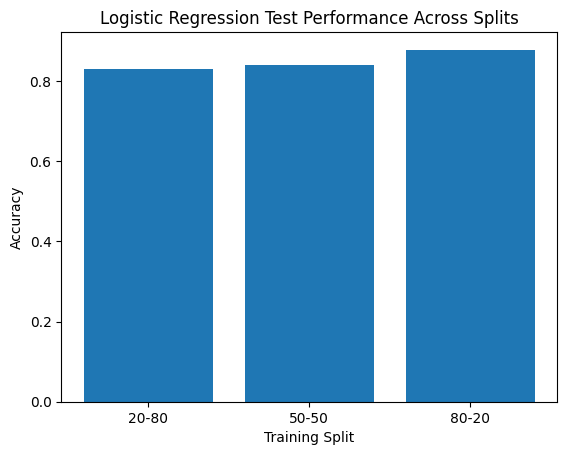

k-Nearest Neighbor model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.9152542372881356, Error: 0.0847457627118644
Pre-tuning testing accuracy: 0.8235294117647058, Error: 0.17647058823529416
Best k: 5, Best weights: uniform, Best metric: euclidean
Best training error: 0.11864406779661019, Best testing error: 0.17226890756302526

Run 2:
Pre-tuning training accuracy: 0.847457627118644, Error: 0.15254237288135597
Pre-tuning testing accuracy: 0.7857142857142857, Error: 0.2142857142857143
Best k: 5, Best weights: uniform, Best metric: euclidean
Best training error: 0.13559322033898302, Best testing error: 0.20588235294117652

Run 3:
Pre-tuning training accuracy: 0.864406779661017, Error: 0.13559322033898302
Pre-tuning testing accuracy: 0.8109243697478992, Error: 0.18907563025210083
Best k: 11, Best weights: uniform, Best metric: manhattan
Best training error: 0.288135593220339, Best testing error: 0.16386554621848737

Average train accurracy: 0.8192090395480226
Aver

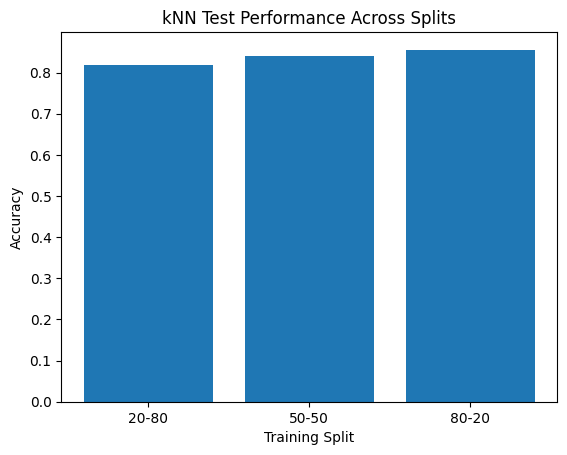

SVM model: 

Linear kernel: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.9322033898305084, Error: 0.06779661016949157
Pre-tuning testing accuracy: 0.7478991596638656, Error: 0.25210084033613445
Best C: 0.001
Best training error: 0.13559322033898302, Best testing error: 0.15966386554621848

Run 2:
Pre-tuning training accuracy: 0.9152542372881356, Error: 0.0847457627118644
Pre-tuning testing accuracy: 0.7563025210084033, Error: 0.24369747899159666
Best C: 1e-07
Best training error: 0.13559322033898302, Best testing error: 0.16806722689075626

Run 3:
Pre-tuning training accuracy: 0.7796610169491526, Error: 0.22033898305084743
Pre-tuning testing accuracy: 0.8529411764705882, Error: 0.1470588235294118
Best C: 1e-07
Best training error: 0.2033898305084746, Best testing error: 0.1470588235294118

Average train accurracy: 0.8418079096045198
Average test accurracy: 0.8417366946778712

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.8918918918918919, 

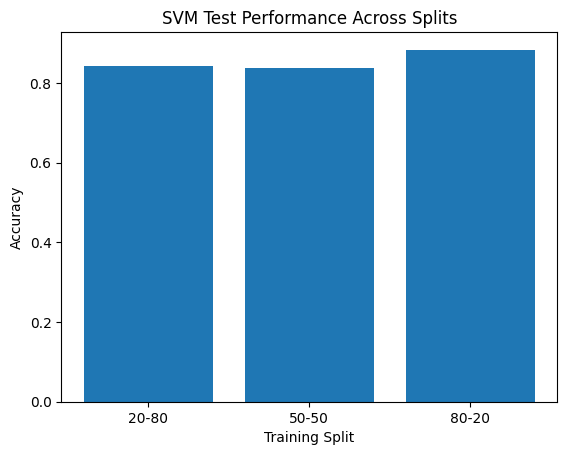


Random Forest model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.8235294117647058, Error: 0.17647058823529416
Best max_features: 1
Best training error: 0.0, Best testing error: 0.16386554621848737

Run 2:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.8109243697478992, Error: 0.18907563025210083
Best max_features: 1
Best training error: 0.0, Best testing error: 0.18487394957983194

Run 3:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.8319327731092437, Error: 0.16806722689075626
Best max_features: 1
Best training error: 0.0, Best testing error: 0.15966386554621848

Average train accurracy: 1.0
Average test accurracy: 0.8305322128851541

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.7919463087248322, Error: 0.20805369127516782
Best max_features: 1
Best training error: 0.0, Best testing error

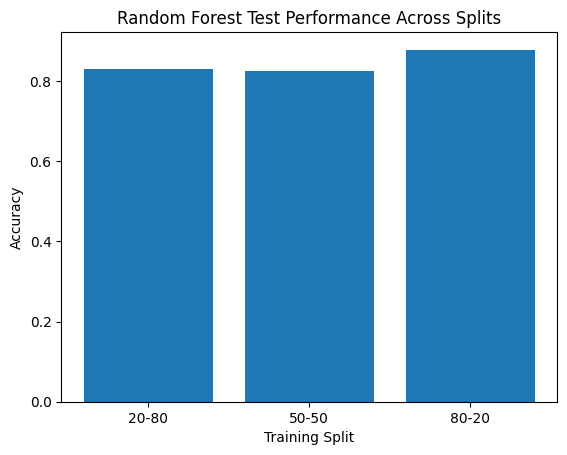

Decision tree model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.7226890756302521, Error: 0.2773109243697479
Best depth: None, Best regularization: 1.0
Best training error: 0.0, Best testing error: 0.2773109243697479

Run 2:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.7394957983193278, Error: 0.26050420168067223
Best depth: 4, Best regularization: 0.001
Best training error: 0.15254237288135597, Best testing error: 0.3067226890756303

Run 3:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.6596638655462185, Error: 0.3403361344537815
Best depth: None, Best regularization: 1.0
Best training error: 0.0, Best testing error: 0.3403361344537815

Average train accurracy: 0.9491525423728814
Average test accurracy: 0.69187675070028

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.7248322147651006, Erro

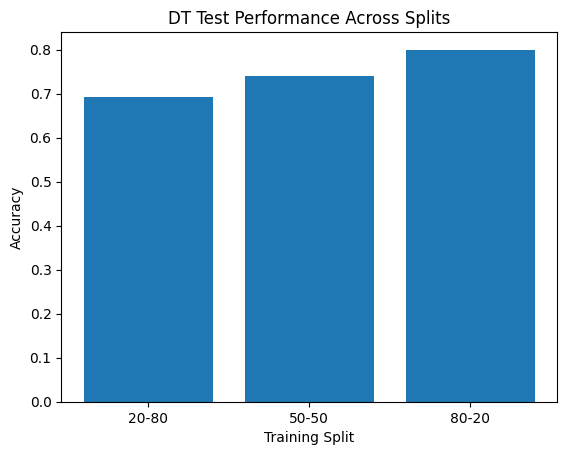

In [34]:
print("Dataset: Heart Disease \n")
best_train, best_test = evaluate_models(X_hd,y_hd)

In [35]:
""" best_svm_RBF_poly_tr = []
best_svm_RBF_poly_te = []
avg_test = []
avg_train = []
print("\nSVM RBF kernel: ")

# fun comparison for smaller dataset
for j in range(3): # iterate through each split
    test_results = list()
    train_results = list()
    print("Using a {}-{} data split \n".format(0.8, 0.2,1))
    for i in range(1,4): # run 3 trials for each data split
        print("Run {}:".format(i))
        train_acc, test_acc = supportvectormachine('rbf',X_hd,y_hd,0.8,rand_list[i-1],svm_param_grid)
        train_results.append(train_acc)
        test_results.append(test_acc)
    
    print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
    print("Average test accurracy: {}".format(sum(test_results)/len(test_results)))
    avg_train.append(sum(train_results)/len(train_results))
    avg_test.append(sum(test_results)/len(test_results))
best_svm_RBF_poly_tr.append(max(avg_train[:3]))
best_svm_RBF_poly_te.append(max(avg_test[:3]))

print("\nPolynomial kernel: ")
for j in range(3): # iterate through each split
    test_results = list()
    train_results = list()
    print("Using a {}-{} data split \n".format(0.8, 0.2))
    for i in range(1,4): # run 3 trials for each data split
        print("Run {}:".format(i))
        train_acc, test_acc = supportvectormachine('poly',X_hd,y_hd,0.8,rand_list[i-1],svm_param_grid)
        train_results.append(train_acc)
        test_results.append(test_acc)
    
    print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
    print("Average test accurracy: {}".format(sum(test_results)/len(test_results)))
    avg_train.append(sum(train_results)/len(train_results))
    avg_test.append(sum(test_results)/len(test_results))
    print("\n")
best_svm_RBF_poly_tr.append(max(avg_train[3:6]))
best_svm_RBF_poly_te.append(max(avg_test[3:6])) """

' best_svm_RBF_poly_tr = []\nbest_svm_RBF_poly_te = []\navg_test = []\navg_train = []\nprint("\nSVM RBF kernel: ")\n\n# fun comparison for smaller dataset\nfor j in range(3): # iterate through each split\n    test_results = list()\n    train_results = list()\n    print("Using a {}-{} data split \n".format(0.8, 0.2,1))\n    for i in range(1,4): # run 3 trials for each data split\n        print("Run {}:".format(i))\n        train_acc, test_acc = supportvectormachine(\'rbf\',X_hd,y_hd,0.8,rand_list[i-1],svm_param_grid)\n        train_results.append(train_acc)\n        test_results.append(test_acc)\n    \n    print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))\n    print("Average test accurracy: {}".format(sum(test_results)/len(test_results)))\n    avg_train.append(sum(train_results)/len(train_results))\n    avg_test.append(sum(test_results)/len(test_results))\nbest_svm_RBF_poly_tr.append(max(avg_train[:3]))\nbest_svm_RBF_poly_te.append(max(avg_test[:3]))\n\n

### German Credit Risk Prediction

Dataset: Statlog 

Logistic Regression model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.855, Error: 0.14500000000000002
Pre-tuning testing accuracy: 0.73, Error: 0.27
Best C: 0.01
Best training error: 0.20999999999999996, Best testing error: 0.2975

Run 2:
Pre-tuning training accuracy: 0.85, Error: 0.15000000000000002
Pre-tuning testing accuracy: 0.68875, Error: 0.31125
Best C: 0.01
Best training error: 0.235, Best testing error: 0.28

Run 3:
Pre-tuning training accuracy: 0.89, Error: 0.10999999999999999
Pre-tuning testing accuracy: 0.71625, Error: 0.28374999999999995
Best C: 0.1
Best training error: 0.14, Best testing error: 0.27125

Average train accurracy: 0.805
Average test accurracy: 0.7170833333333334

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.796, Error: 0.20399999999999996
Pre-tuning testing accuracy: 0.746, Error: 0.254
Best C: 0.01
Best training error: 0.22399999999999998, Best testing error: 0.28

Run 2:
Pre-tuning traini

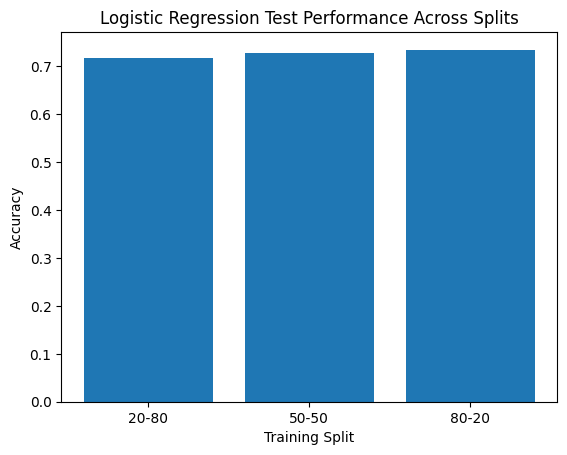

k-Nearest Neighbor model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.88, Error: 0.12
Pre-tuning testing accuracy: 0.7075, Error: 0.2925
Best k: 11, Best weights: uniform, Best metric: manhattan
Best training error: 0.21999999999999997, Best testing error: 0.3075

Run 2:
Pre-tuning training accuracy: 0.845, Error: 0.15500000000000003
Pre-tuning testing accuracy: 0.69375, Error: 0.30625
Best k: 9, Best weights: uniform, Best metric: euclidean
Best training error: 0.235, Best testing error: 0.27125

Run 3:
Pre-tuning training accuracy: 0.83, Error: 0.17000000000000004
Pre-tuning testing accuracy: 0.70375, Error: 0.29625
Best k: 9, Best weights: uniform, Best metric: manhattan
Best training error: 0.20999999999999996, Best testing error: 0.28

Average train accurracy: 0.7783333333333333
Average test accurracy: 0.71375

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.86, Error: 0.14
Pre-tuning testing accuracy: 0.692, Error: 0.30800000000000005

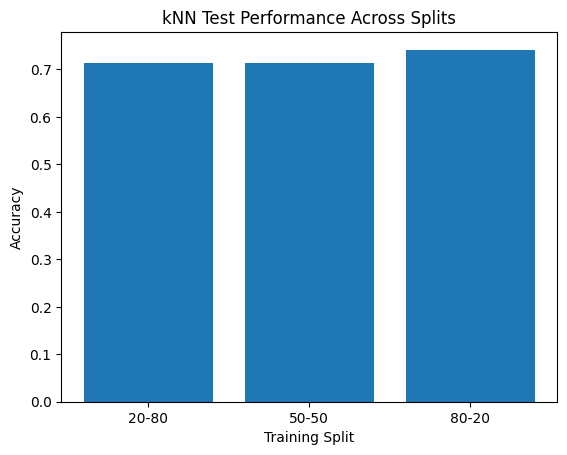

SVM model: 

Linear kernel: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.87, Error: 0.13
Pre-tuning testing accuracy: 0.72375, Error: 0.27625
Best C: 0.1
Best training error: 0.135, Best testing error: 0.27625

Run 2:
Pre-tuning training accuracy: 0.855, Error: 0.14500000000000002
Pre-tuning testing accuracy: 0.67875, Error: 0.32125000000000004
Best C: 0.01
Best training error: 0.17500000000000004, Best testing error: 0.31625000000000003

Run 3:
Pre-tuning training accuracy: 0.89, Error: 0.10999999999999999
Pre-tuning testing accuracy: 0.71375, Error: 0.28625
Best C: 0.1
Best training error: 0.10999999999999999, Best testing error: 0.28874999999999995

Average train accurracy: 0.86
Average test accurracy: 0.7062499999999999

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.8, Error: 0.19999999999999996
Pre-tuning testing accuracy: 0.742, Error: 0.258
Best C: 0.01
Best training error: 0.19199999999999995, Best testing error: 0.252

Run 2:
Pre-

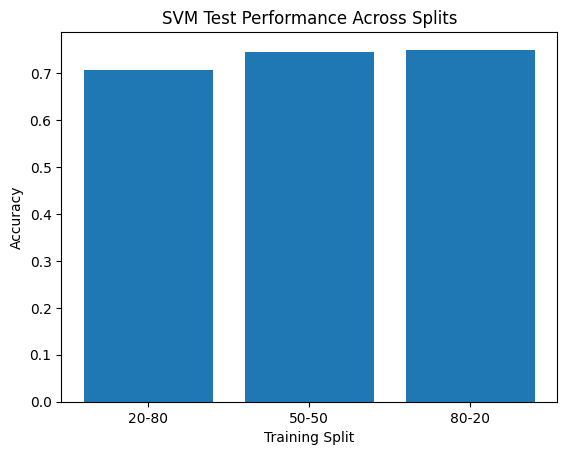


Random Forest model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.70875, Error: 0.29125
Best max_features: 2
Best training error: 0.0, Best testing error: 0.29874999999999996

Run 2:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.72125, Error: 0.27875000000000005
Best max_features: 4
Best training error: 0.0, Best testing error: 0.27249999999999996

Run 3:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.7325, Error: 0.26749999999999996
Best max_features: 6
Best training error: 0.0, Best testing error: 0.26875000000000004

Average train accurracy: 1.0
Average test accurracy: 0.7200000000000001

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.728, Error: 0.272
Best max_features: 8
Best training error: 0.0, Best testing error: 0.27

Run 2:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning t

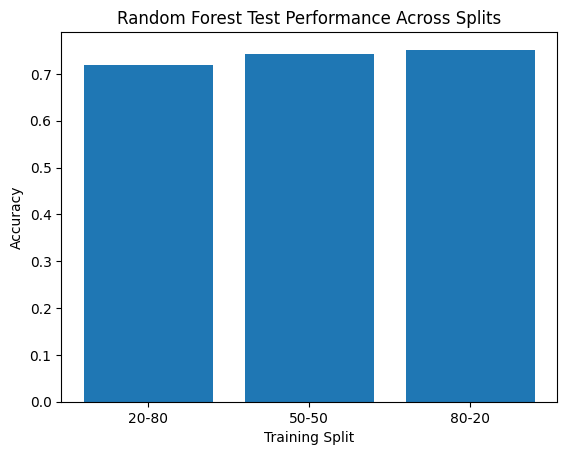

Decision tree model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.68, Error: 0.31999999999999995
Best depth: 2, Best regularization: 1.0
Best training error: 0.245, Best testing error: 0.31375

Run 2:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.665, Error: 0.33499999999999996
Best depth: 1, Best regularization: 0.001
Best training error: 0.31499999999999995, Best testing error: 0.29625

Run 3:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.66375, Error: 0.33625000000000005
Best depth: 5, Best regularization: 0.1
Best training error: 0.20499999999999996, Best testing error: 0.29125

Average train accurracy: 0.7450000000000001
Average test accurracy: 0.6995833333333333

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.694, Error: 0.30600000000000005
Best depth: 5, Best regularization: 0.001
Bes

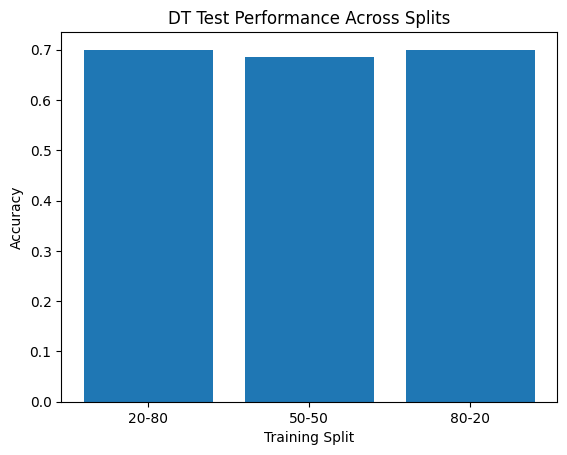

In [36]:
print("Dataset: Statlog \n")
best_train1, best_test1 = evaluate_models(X_statlog,y_statlog)

In [37]:
""" best_svm_RBF_poly_tr = []
best_svm_RBF_poly_te = []
avg_test = []
avg_train = []
print("\nSVM RBF kernel: ")

# fun comparison for smaller dataset
for j in range(3): # iterate through each split
    test_results = list()
    train_results = list()
    print("Using a {}-{} data split \n".format(0.8, 0.2,1))
    for i in range(1,4): # run 3 trials for each data split
        print("Run {}:".format(i))
        train_acc, test_acc = supportvectormachine('rbf',X_statlog,y_statlog,0.8,rand_list[i-1],svm_param_grid)
        train_results.append(train_acc)
        test_results.append(test_acc)
    
    print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
    print("Average test accurracy: {}".format(sum(test_results)/len(test_results)))
    avg_train.append(sum(train_results)/len(train_results))
    avg_test.append(sum(test_results)/len(test_results))
best_svm_RBF_poly_tr.append(max(avg_train[:3]))
best_svm_RBF_poly_te.append(max(avg_test[:3]))

print("\nPolynomial kernel: ")
for j in range(3): # iterate through each split
    test_results = list()
    train_results = list()
    print("Using a {}-{} data split \n".format(0.8, 0.2))
    for i in range(1,4): # run 3 trials for each data split
        print("Run {}:".format(i))
        train_acc, test_acc = supportvectormachine('poly',X_statlog,y_statlog,0.8,rand_list[i-1],svm_param_grid)
        train_results.append(train_acc)
        test_results.append(test_acc)
    
    print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))
    print("Average test accurracy: {}".format(sum(test_results)/len(test_results)))
    avg_train.append(sum(train_results)/len(train_results))
    avg_test.append(sum(test_results)/len(test_results))
    print("\n")
best_svm_RBF_poly_tr.append(max(avg_train[3:6]))
best_svm_RBF_poly_te.append(max(avg_test[3:6])) """

' best_svm_RBF_poly_tr = []\nbest_svm_RBF_poly_te = []\navg_test = []\navg_train = []\nprint("\nSVM RBF kernel: ")\n\n# fun comparison for smaller dataset\nfor j in range(3): # iterate through each split\n    test_results = list()\n    train_results = list()\n    print("Using a {}-{} data split \n".format(0.8, 0.2,1))\n    for i in range(1,4): # run 3 trials for each data split\n        print("Run {}:".format(i))\n        train_acc, test_acc = supportvectormachine(\'rbf\',X_statlog,y_statlog,0.8,rand_list[i-1],svm_param_grid)\n        train_results.append(train_acc)\n        test_results.append(test_acc)\n    \n    print("Average train accurracy: {}".format(sum(train_results)/len(train_results)))\n    print("Average test accurracy: {}".format(sum(test_results)/len(test_results)))\n    avg_train.append(sum(train_results)/len(train_results))\n    avg_test.append(sum(test_results)/len(test_results))\nbest_svm_RBF_poly_tr.append(max(avg_train[:3]))\nbest_svm_RBF_poly_te.append(max(avg_test

### Adult Prediction

The paper I read that uses this dataset, titled "Fair Logistic Regression: An Adversarial Perspective" drops nflwgt since the weightings aren't considered for model analysis, and education since it's redundant (encodes same information, just in categorical form) with education-num

Dataset: Adult 

Logistic Regression model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.831, Error: 0.16900000000000004
Pre-tuning testing accuracy: 0.825, Error: 0.17500000000000004
Best C: 10
Best training error: 0.16700000000000004, Best testing error: 0.17574999999999996

Run 2:
Pre-tuning training accuracy: 0.818, Error: 0.18200000000000005
Pre-tuning testing accuracy: 0.819, Error: 0.18100000000000005
Best C: 1
Best training error: 0.18200000000000005, Best testing error: 0.18100000000000005

Run 3:
Pre-tuning training accuracy: 0.832, Error: 0.16800000000000004
Pre-tuning testing accuracy: 0.8255, Error: 0.1745
Best C: 1
Best training error: 0.16800000000000004, Best testing error: 0.1745

Average train accurracy: 0.8276666666666666
Average test accurracy: 0.8229166666666666

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.8244, Error: 0.17559999999999998
Pre-tuning testing accuracy: 0.8304, Error: 0.16959999999999997
Best C: 100
Bes

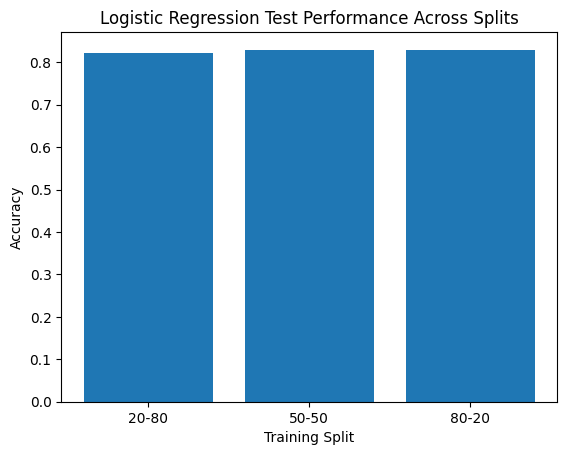

k-Nearest Neighbor model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.878, Error: 0.122
Pre-tuning testing accuracy: 0.78675, Error: 0.21325000000000005
Best k: 11, Best weights: uniform, Best metric: manhattan
Best training error: 0.17300000000000004, Best testing error: 0.1945

Run 2:
Pre-tuning training accuracy: 0.877, Error: 0.123
Pre-tuning testing accuracy: 0.781, Error: 0.21899999999999997
Best k: 9, Best weights: uniform, Best metric: euclidean
Best training error: 0.16500000000000004, Best testing error: 0.1995

Run 3:
Pre-tuning training accuracy: 0.86, Error: 0.14
Pre-tuning testing accuracy: 0.78825, Error: 0.21175
Best k: 9, Best weights: uniform, Best metric: euclidean
Best training error: 0.15600000000000003, Best testing error: 0.20299999999999996

Average train accurracy: 0.8353333333333333
Average test accurracy: 0.801

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.8756, Error: 0.12439999999999996
Pre-tuning testing acc

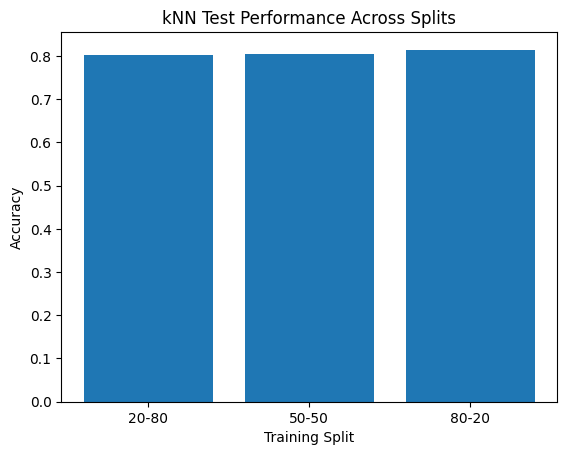

SVM model: 

Linear kernel: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.837, Error: 0.16300000000000003
Pre-tuning testing accuracy: 0.82275, Error: 0.17725000000000002
Best C: 1
Best training error: 0.16300000000000003, Best testing error: 0.17725000000000002

Run 2:
Pre-tuning training accuracy: 0.823, Error: 0.17700000000000005
Pre-tuning testing accuracy: 0.82125, Error: 0.17874999999999996
Best C: 0.1
Best training error: 0.17600000000000005, Best testing error: 0.18025000000000002

Run 3:
Pre-tuning training accuracy: 0.829, Error: 0.17100000000000004
Pre-tuning testing accuracy: 0.82475, Error: 0.17525000000000002
Best C: 0.01
Best training error: 0.17400000000000004, Best testing error: 0.17700000000000005

Average train accurracy: 0.8290000000000001
Average test accurracy: 0.8218333333333333

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.8244, Error: 0.17559999999999998
Pre-tuning testing accuracy: 0.8316, Error: 0.1684
Best C: 1

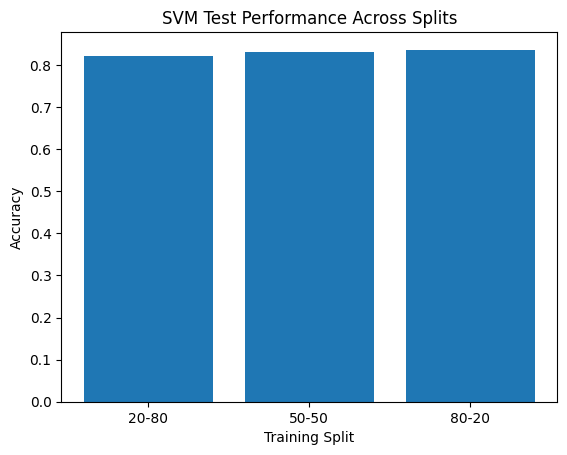


Random Forest model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.988, Error: 0.01200000000000001
Pre-tuning testing accuracy: 0.8145, Error: 0.1855
Best max_features: 2
Best training error: 0.01200000000000001, Best testing error: 0.18400000000000005

Run 2:
Pre-tuning training accuracy: 0.985, Error: 0.015000000000000013
Pre-tuning testing accuracy: 0.80725, Error: 0.19274999999999998
Best max_features: 4
Best training error: 0.015000000000000013, Best testing error: 0.19274999999999998

Run 3:
Pre-tuning training accuracy: 0.99, Error: 0.010000000000000009
Pre-tuning testing accuracy: 0.809, Error: 0.19099999999999995
Best max_features: 4
Best training error: 0.010000000000000009, Best testing error: 0.19099999999999995

Average train accurracy: 0.9876666666666667
Average test accurracy: 0.81075

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.9756, Error: 0.024399999999999977
Pre-tuning testing accuracy: 0.8148, Error: 0.185200000000000

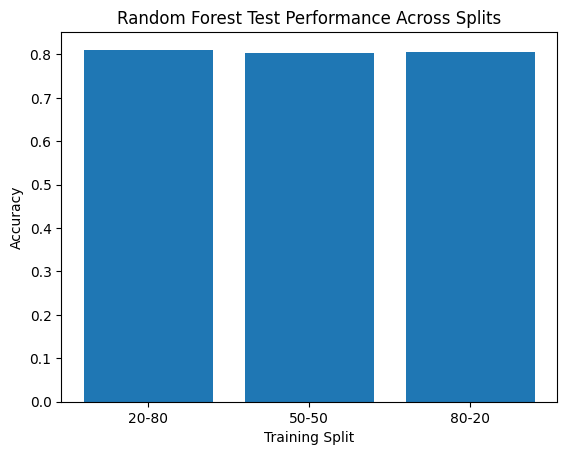

Decision tree model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.988, Error: 0.01200000000000001
Pre-tuning testing accuracy: 0.77525, Error: 0.22475
Best depth: 3, Best regularization: 1.0
Best training error: 0.18700000000000006, Best testing error: 0.20899999999999996

Run 2:
Pre-tuning training accuracy: 0.985, Error: 0.015000000000000013
Pre-tuning testing accuracy: 0.754, Error: 0.246
Best depth: 3, Best regularization: 1.0
Best training error: 0.19599999999999995, Best testing error: 0.2005

Run 3:
Pre-tuning training accuracy: 0.99, Error: 0.010000000000000009
Pre-tuning testing accuracy: 0.7735, Error: 0.22650000000000003
Best depth: 4, Best regularization: 1.0
Best training error: 0.16900000000000004, Best testing error: 0.18574999999999997

Average train accurracy: 0.816
Average test accurracy: 0.8015833333333333

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.9756, Error: 0.024399999999999977
Pre-tuning testing accuracy: 0.7936

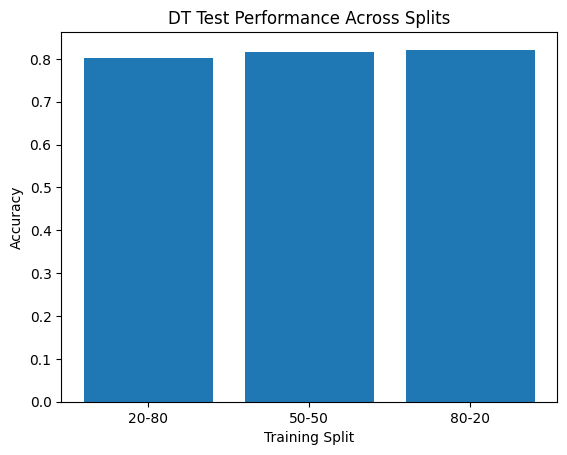

In [38]:
print("Dataset: Adult \n")
best_train2, best_test2 = evaluate_models(X_adult,y_adult)

### Cover Type Prediction

Dataset: Cover Type 

Logistic Regression model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.761, Error: 0.239
Pre-tuning testing accuracy: 0.757, Error: 0.243
Best C: 10
Best training error: 0.24050000000000005, Best testing error: 0.243375

Run 2:
Pre-tuning training accuracy: 0.7615, Error: 0.23850000000000005
Pre-tuning testing accuracy: 0.762625, Error: 0.237375
Best C: 10
Best training error: 0.239, Best testing error: 0.237

Run 3:
Pre-tuning training accuracy: 0.766, Error: 0.23399999999999999
Pre-tuning testing accuracy: 0.7585, Error: 0.24150000000000005
Best C: 1000
Best training error: 0.23399999999999999, Best testing error: 0.24124999999999996

Average train accurracy: 0.7621666666666668
Average test accurracy: 0.7594583333333333

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.7702, Error: 0.2298
Pre-tuning testing accuracy: 0.7568, Error: 0.24319999999999997
Best C: 100
Best training error: 0.23019999999999996, Best testing 

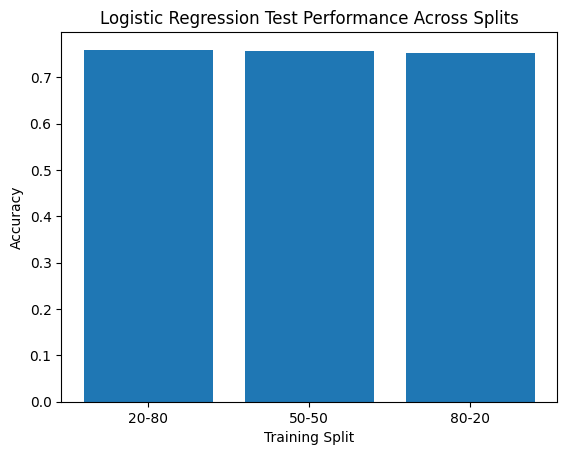

k-Nearest Neighbor model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.855, Error: 0.14500000000000002
Pre-tuning testing accuracy: 0.7345, Error: 0.26549999999999996
Best k: 11, Best weights: distance, Best metric: manhattan
Best training error: 0.0, Best testing error: 0.25887499999999997

Run 2:
Pre-tuning training accuracy: 0.8535, Error: 0.14649999999999996
Pre-tuning testing accuracy: 0.7355, Error: 0.26449999999999996
Best k: 7, Best weights: distance, Best metric: manhattan
Best training error: 0.0, Best testing error: 0.24575000000000002

Run 3:
Pre-tuning training accuracy: 0.8755, Error: 0.12450000000000006
Pre-tuning testing accuracy: 0.73025, Error: 0.26975000000000005
Best k: 7, Best weights: distance, Best metric: manhattan
Best training error: 0.0, Best testing error: 0.254

Average train accurracy: 1.0
Average test accurracy: 0.747125

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.8862, Error: 0.11380000000000001
Pre-tunin

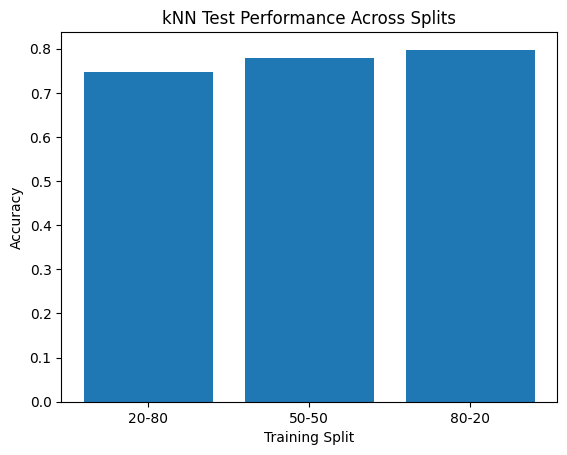

SVM model: 

Linear kernel: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 0.76, Error: 0.24
Pre-tuning testing accuracy: 0.75975, Error: 0.24024999999999996
Best C: 1
Best training error: 0.24, Best testing error: 0.24024999999999996

Run 2:
Pre-tuning training accuracy: 0.7595, Error: 0.24050000000000005
Pre-tuning testing accuracy: 0.7625, Error: 0.23750000000000004
Best C: 100
Best training error: 0.24050000000000005, Best testing error: 0.23787499999999995

Run 3:
Pre-tuning training accuracy: 0.765, Error: 0.235
Pre-tuning testing accuracy: 0.759, Error: 0.241
Best C: 1
Best training error: 0.235, Best testing error: 0.241

Average train accurracy: 0.7615
Average test accurracy: 0.7602916666666667

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 0.77, Error: 0.22999999999999998
Pre-tuning testing accuracy: 0.7588, Error: 0.24119999999999997
Best C: 1
Best training error: 0.22999999999999998, Best testing error: 0.24119999999999997

Run 2:
Pr

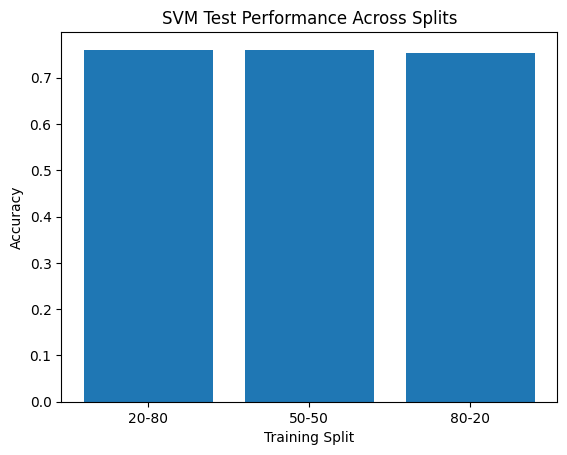


Random Forest model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.797, Error: 0.20299999999999996
Best max_features: 8
Best training error: 0.0, Best testing error: 0.20325000000000004

Run 2:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.7985, Error: 0.2015
Best max_features: 6
Best training error: 0.0, Best testing error: 0.20074999999999998

Run 3:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.782375, Error: 0.21762499999999996
Best max_features: 8
Best training error: 0.0, Best testing error: 0.217125

Average train accurracy: 1.0
Average test accurracy: 0.7929583333333333

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.8208, Error: 0.17920000000000003
Best max_features: 8
Best training error: 0.0, Best testing error: 0.17959999999999998

Run 2:
Pre-tuning training accuracy: 1.0, Error:

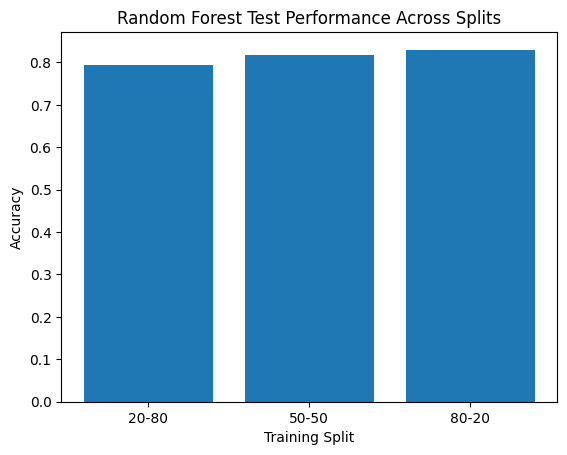

Decision tree model: 

Using a 0.2-0.8 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.724, Error: 0.276
Best depth: 5, Best regularization: 1.0
Best training error: 0.23399999999999999, Best testing error: 0.25675000000000003

Run 2:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.728875, Error: 0.27112499999999995
Best depth: 5, Best regularization: 1.0
Best training error: 0.22999999999999998, Best testing error: 0.25925

Run 3:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.720375, Error: 0.279625
Best depth: 4, Best regularization: 1.0
Best training error: 0.23450000000000004, Best testing error: 0.258375

Average train accurracy: 0.7671666666666667
Average test accurracy: 0.741875

Using a 0.5-0.5 data split 

Run 1:
Pre-tuning training accuracy: 1.0, Error: 0.0
Pre-tuning testing accuracy: 0.745, Error: 0.255
Best depth: 10, Best regularization: 1.0
Best training error: 0.

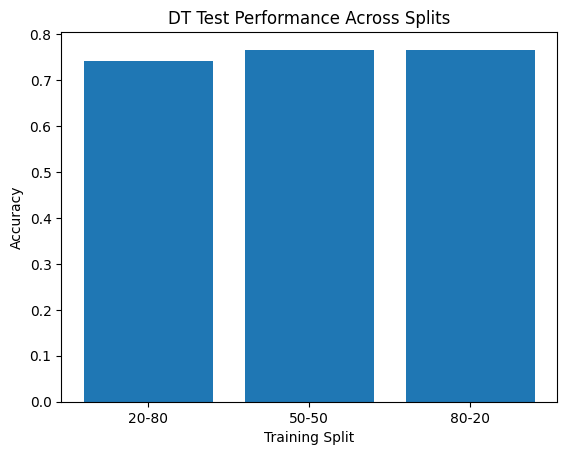

In [39]:
print("Dataset: Cover Type \n")
best_train3, best_test3 = evaluate_models(X_cov,y_cov)

## Results

In [40]:
print("Model ordering: Logreg, kNN, SVM Linear, Random Forest, Decision Tree\n")
print("Task 1: Heart Disese")
print("Training accuracies:")
print(best_train)
print("Testing accuracies: ")
print(best_test)
print("\nTask 2: Statlog")
print("Training accuracies:")
print(best_train1)
print("Testing accuracies: ")
print(best_test1)
print("\nTask 3: Adult")
print("Training accuracies:")
print(best_train2)
print("Testing accuracies: ")
print(best_test2)
print("\nTask 4: Cover Type")
print("Training accuracies:")
print(best_train3)
print("Testing accuracies: ")
print(best_test3)

Model ordering: Logreg, kNN, SVM Linear, Random Forest, Decision Tree

Task 1: Heart Disese
Training accuracies:
[0.8490990990990991, 0.9240506329113924, 0.8423423423423424, 1.0, 0.9491525423728814]
Testing accuracies: 
[0.8777777777777778, 0.8555555555555555, 0.8833333333333333, 0.8777777777777778, 0.7999999999999999]

Task 2: Statlog
Training accuracies:
[0.805, 0.9326666666666666, 0.86, 1.0, 0.7450000000000001]
Testing accuracies: 
[0.735, 0.7416666666666667, 0.75, 0.7516666666666666, 0.7000000000000001]

Task 3: Adult
Training accuracies:
[0.8276666666666666, 0.83575, 0.8290000000000001, 0.9876666666666667, 0.8536]
Testing accuracies: 
[0.8296666666666667, 0.8143333333333334, 0.8363333333333333, 0.81075, 0.8213333333333334]

Task 4: Cover Type
Training accuracies:
[0.7696666666666667, 1.0, 0.7710666666666667, 1.0, 0.8933333333333332]
Testing accuracies: 
[0.7594583333333333, 0.7978333333333333, 0.7602916666666667, 0.8298333333333333, 0.766]


In [53]:
training_accs = np.vstack((best_train,best_train1,best_train2,best_train3))
testing_accs = np.vstack((best_test,best_test1,best_test2,best_test3))
models = ["LOGREG","KNN","LinSVM","RF", "DT"]

train_table = pd.DataFrame(training_accs, columns=models)
test_table = pd.DataFrame(testing_accs, columns=models)
print("\n Best training accuracies: ")
train_table = train_table.T
train_table.columns = ['HD','STAT','ADULT','COV']
train_table


 Best training accuracies: 


,HD,STAT,ADULT,COV
LOGREG,0.849099,0.805000,0.827667,0.769667
KNN,0.924051,0.932667,0.835750,1.000000
LinSVM,0.842342,0.860000,0.829000,0.771067
RF,1.000000,1.000000,0.987667,1.000000
DT,0.949153,0.745000,0.853600,0.893333


In [52]:
print("\n Best testing accuracies (across data splits): ")
test_table = test_table.T
test_table.columns = ['HD','STAT','ADULT','COV']
test_table


 Best testing accuracies (across data splits): 


,HD,STAT,ADULT,COV
LOGREG,0.877778,0.735000,0.829667,0.759458
KNN,0.855556,0.741667,0.814333,0.797833
LinSVM,0.883333,0.750000,0.836333,0.760292
RF,0.877778,0.751667,0.810750,0.829833
DT,0.800000,0.700000,0.821333,0.766000


In [49]:
means = test_table.mean()
means_df = pd.DataFrame(means).T

In [50]:
print(means_df)

     LOGREG       KNN   LinSVM        RF        DT
0  0.800476  0.802347  0.80749  0.817507  0.771833
